In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision

In [3]:
# Hyperparameters
latent_dim = 100
img_size = 64
batch_size = 256
epochs = 10
lr = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)  # Set device 0

In [2]:
torch.cuda.is_available()

False

In [4]:
# # Use DataParallel to enable both T4 GPUs
# generator = nn.DataParallel(generator)
# discriminator = nn.DataParallel(discriminator)

NameError: name 'generator' is not defined

In [5]:
# Image Transform
transform = transforms.Compose([transforms.Resize(img_size),
                                transforms.CenterCrop(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
# Dataset & Dataloader from Kaggle path
data_path = '/kaggle/input/celeba-dataset/img_align_celeba/'
dataset = torchvision.datasets.ImageFolder(root=data_path, transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)


In [29]:
# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [30]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(1024, 1, 4, 1, 0, bias=False)
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)

# Initialize weights (Critical for stable training)
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)

DataParallel(
  (module): Discriminator(
    (model): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
      (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.1, inplace=True)
      (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.1, inplace=True)
      (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.1, inplace=True)
      (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False

In [31]:
# Initialize networks
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [32]:
if torch.cuda.device_count() > 1:
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)

In [33]:
# Loss & Optimizers
criterion = nn.BCEWithLogitsLoss()
g_optim = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999), weight_decay=1e-5)
d_optim = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=1e-5)


In [34]:
# Mixed Precision Training (Faster)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-34-8ced612859fa>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


<ipython-input-35-36c1485a4e3d>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-35-36c1485a4e3d>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/10] | Batch [792/792] | D Loss: 0.2294 | G Loss: 3.80856


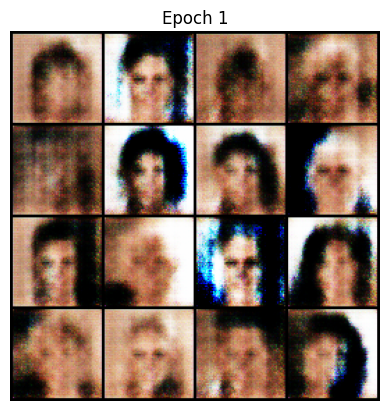

Epoch [2/10] | Batch [792/792] | D Loss: 0.2428 | G Loss: 6.00917


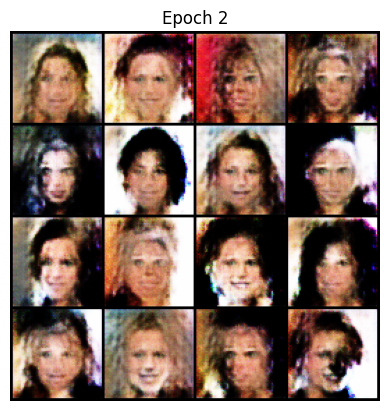

Epoch [3/10] | Batch [792/792] | D Loss: 0.2068 | G Loss: 4.21963


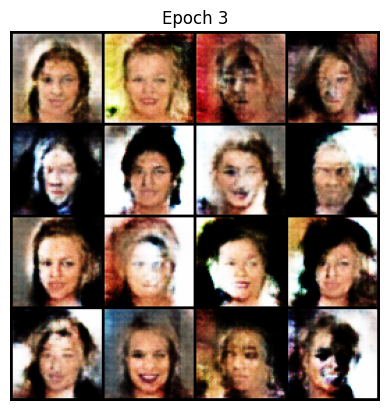

Epoch [4/10] | Batch [792/792] | D Loss: 0.2583 | G Loss: 4.0101


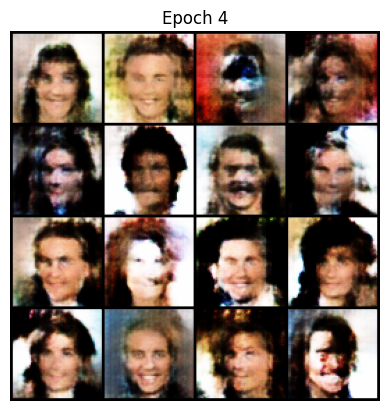

Epoch [5/10] | Batch [792/792] | D Loss: 0.1714 | G Loss: 4.46558


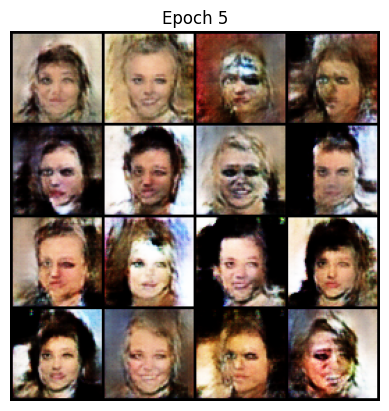

Epoch [6/10] | Batch [792/792] | D Loss: 0.1996 | G Loss: 5.30544


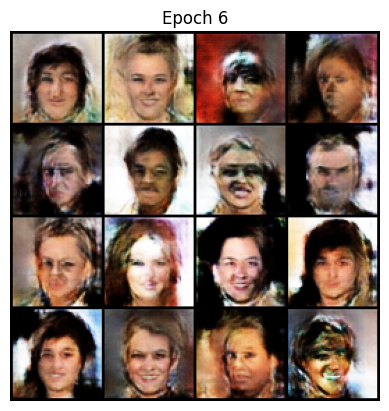

Epoch [7/10] | Batch [792/792] | D Loss: 0.1878 | G Loss: 4.51489


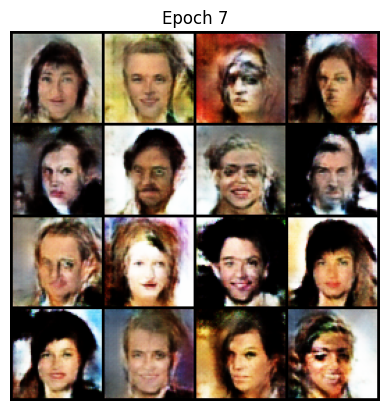

Epoch [8/10] | Batch [792/792] | D Loss: 0.1834 | G Loss: 5.28631
Epoch [10/10] | Batch [404/792] | D Loss: 0.1884 | G Loss: 5.2658

In [ ]:
import sys

fixed_noise = torch.randn(16, latent_dim, 1, 1, device=device)

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        real_labels = torch.full((batch_size, 1), 0.9, device=device)  # Soft Labels for real
        fake_labels = torch.full((batch_size, 1), 0.0, device=device)  # Hard Labels for fake

        # Train Discriminator
        d_optim.zero_grad()
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise).detach()  # Detach to avoid updating G
        
        with torch.cuda.amp.autocast():
            real_loss = criterion(discriminator(real_images), real_labels)
            fake_loss = criterion(discriminator(fake_images), fake_labels)
            d_loss = (real_loss + fake_loss) * 0.5  # Averaging for stability

        scaler.scale(d_loss).backward()
        scaler.step(d_optim)
        scaler.update()

        # Train Generator (More Frequent Updates)
        if i % 3 == 0:  # Update Generator 3 times less than Discriminator
            g_optim.zero_grad()
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = generator(noise)
            
            with torch.cuda.amp.autocast():
                g_loss = criterion(discriminator(fake_images), real_labels)  # Fooling D

            scaler.scale(g_loss).backward()
            scaler.step(g_optim)
            scaler.update()

        # Logging
        sys.stdout.write(f"\rEpoch [{epoch+1}/{epochs}] | Batch [{i+1}/{len(dataloader)}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
        sys.stdout.flush()
    print()
  # Move to the next line after each epoch completes

    # Save Images Every Epoch
    with torch.no_grad():
        fake_images = generator(fixed_noise).cpu()
        grid = torchvision.utils.make_grid(fake_images, nrow=4, normalize=True)
        plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
        plt.title(f"Epoch {epoch+1}")
        plt.axis("off")
        plt.show()
